# Data Mining 


In [35]:
# Import libraries to be used:
# libraries used are for model loading/statistical analysis/dataloading

import pandas as pd
import matplotlib.pyplot as plt
import random 1
import numpy as np
from scipy.stats import pearsonr,spearmanr
from PIL import Image

import skimage
from skimage.color import rgb2hed,rgba2rgb
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights


## Question No. 1: (Data Analysis) 

In [36]:
# Read CSV, the CSV file contains all labels for images
df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')

df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field

df = df.set_index('image_id').sort_index()

protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']

#Set File containing images
image_folder = './patches_256/'

# Create new dataset with specimen_id, image_id and proteins for analysis
# We are using a sample of 1000 data due computation complexity

new_data = df[['EGFR','PTEN','SOX2','NESTIN','cMYC','MET','specimen_id']].sample(n=4000)
labels = new_data[['EGFR','PTEN','SOX2','NESTIN','cMYC','MET','specimen_id']]
train_data = []
test_data = []

training = new_data[new_data.specimen_id != 'C1']
test = new_data[new_data.specimen_id == 'C1']
#Store images in array that are in sample in all_images array
#We are not using any images that do not have labels for the training process
for image in training.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    train_data.append(I)

for image in test.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    test_data.append(I)

In [37]:
# Split data into training, validation and testing
# We will be ising X_Train and y_train in question 1.

X_train, X_val, y_train, y_val = train_test_split(train_data, training, train_size=0.8, random_state=42)
X_test = test_data
y_test = test

**i. Counting Examples: Determine the number of "examples" or spots present in each specimen.**


In [38]:
print('A1 spot examples in training data',(y_train['specimen_id'] == 'A1').sum())
print('C1 spot examples in training data',(y_train['specimen_id'] == 'B1').sum())
print('C1 spot examples in training data',(y_train['specimen_id']== 'C1').sum())
print('D1 spot examples in training data',(y_train['specimen_id'] == 'D1').sum())

A1 spot examples in training data 966
C1 spot examples in training data 371
C1 spot examples in training data 0
D1 spot examples in training data 564


Using the data provided from our sample of 3000 data, in our training data:

| Specimen | Number of Samples |
|----------|-------------------|
| A1       | 966               |
| B1       | 371               |
| C1       | 0                 |
| D1       | 564               |

Note : We are only using data from specimens A1, B1 and D1 for training and validation

**ii. Protein Expression Histograms: For each specimen, generate histograms to visualize the expression values of 'NESTIN', 'cMYC', and 'MET' and discuss your observations.**

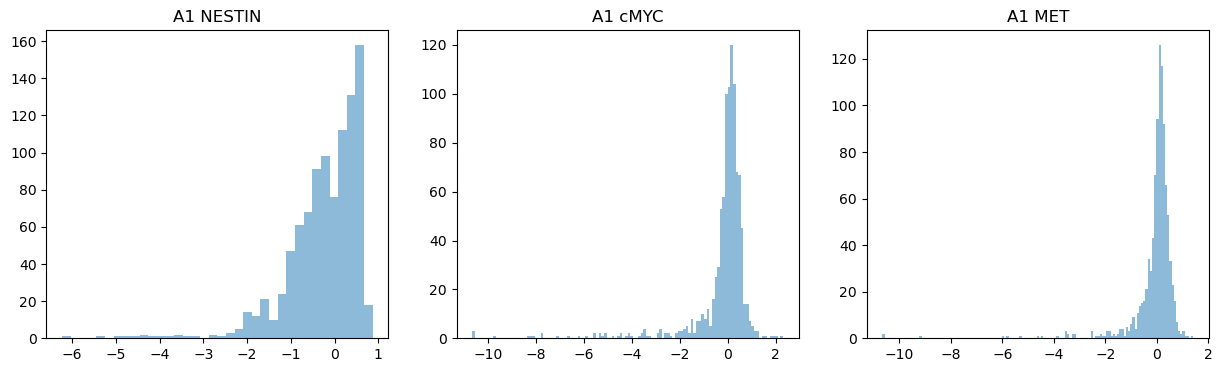

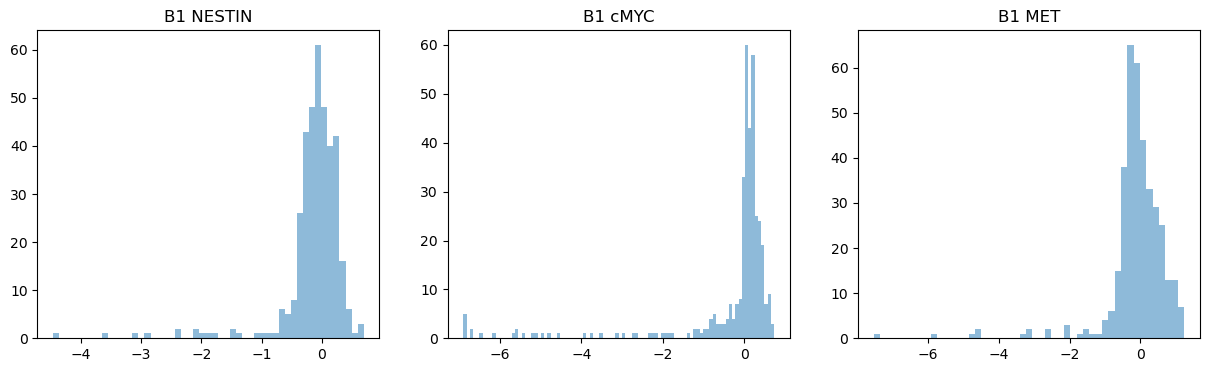

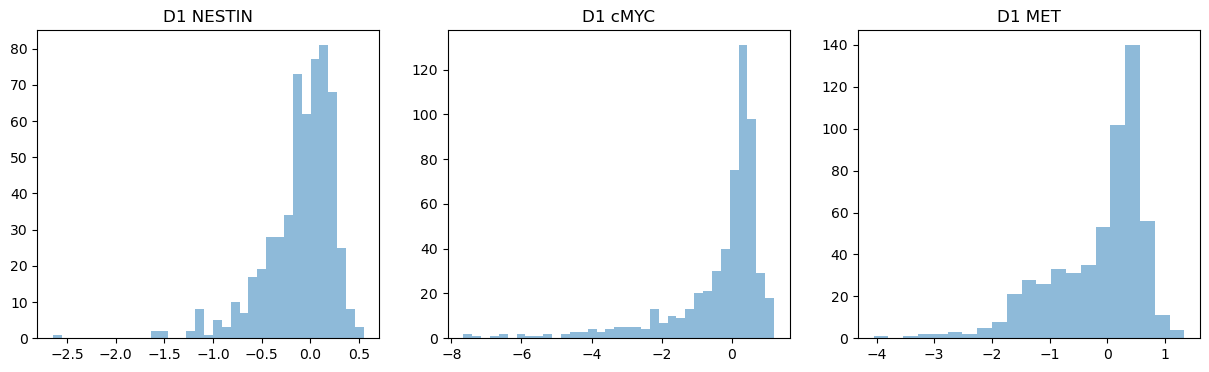

In [39]:
spec_A1 = y_train[y_train['specimen_id'] == 'A1']
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3, figsize=(15, 4))
ax0.hist(spec_A1[['NESTIN']], bins='auto', alpha=0.5)
ax0.set_title('A1 NESTIN')
ax1.hist(spec_A1[['cMYC']], bins='auto', alpha=0.5)
ax1.set_title('A1 cMYC')
ax2.hist(spec_A1[['MET']], bins='auto', alpha=0.5)
ax2.set_title('A1 MET')
plt.show() 

spec_B1 = y_train[y_train['specimen_id']  == 'B1']
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3, figsize=(15, 4))
ax0.hist(spec_B1[['NESTIN']], bins='auto', alpha=0.5)
ax0.set_title('B1 NESTIN')
ax1.hist(spec_B1[['cMYC']], bins='auto', alpha=0.5)
ax1.set_title('B1 cMYC')
ax2.hist(spec_B1[['MET']], bins='auto', alpha=0.5)
ax2.set_title('B1 MET')
plt.show() 

spec_D1 = y_train[y_train['specimen_id']  == 'D1']
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3, figsize=(15, 4))
ax0.hist(spec_D1[['NESTIN']], bins='auto', alpha=0.5)
ax0.set_title('D1 NESTIN')
ax1.hist(spec_D1[['cMYC']], bins='auto', alpha=0.5)
ax1.set_title('D1 cMYC')
ax2.hist(spec_D1[['MET']], bins='auto', alpha=0.5)
ax2.set_title('D1 MET')
plt.show() 

ii. Protein Expression Histograms: For each specimen, generate histograms to visualize the expression values of 'NESTIN', 'cMYC', and 'MET' and discuss your observations. 

The graphs show the expression values of 'NESTIN', 'cMYC', and 'MET' and their frequency in the training dataset. From all data we are able to observe that:
- Data is a mix of positive an negative values
- Overall there is a greater number of posotive expression values for all speicimens (Data is skewed to the right)
- Greater variance of expression values in MET
- A1 MET  is shown to have very few outliers 
- B1 is shown to have lower frequency of protein expressions compared to A1 and D1



**iii. Image Pre-processing: Convert a selection of images from RGB to HED color space, focusing on the Hematoxylin channel (H) to highlight cellular nuclei. Provide visual examples and follow the hints in the provided notebook.**

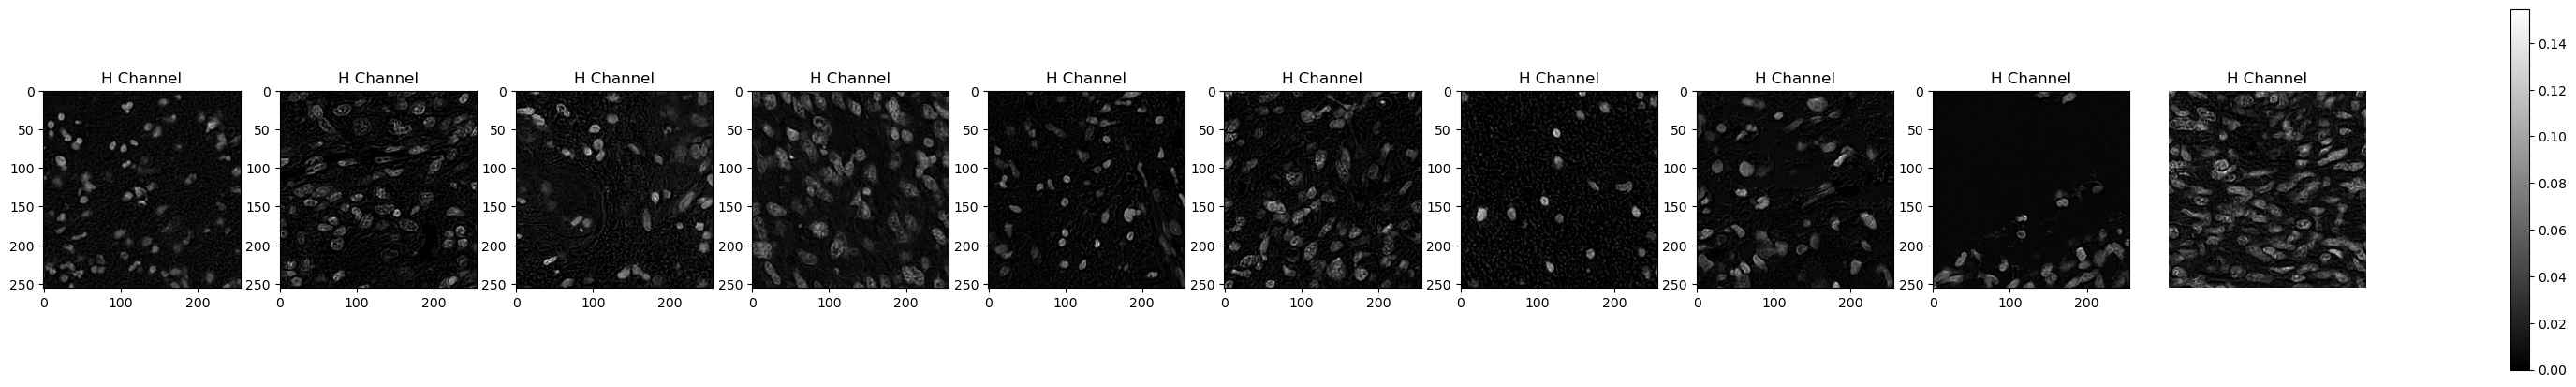

In [40]:
fig, ax = plt.subplots(1, 10, figsize=(40, 5))

#Display random sample of 10 images of training set
sampled_data = random.sample(X_train,10)

for i, image in enumerate(sampled_data):
    if(image.shape[-1] == 4): #if in rgba
        image = rgba2rgb(image) 
    I_hed = rgb2hed(image) #convert image to HED
    I_h = I_hed[:,:,0] #select H channel
    im = ax[i].imshow(I_h,cmap='gray')
    ax[i].set_title('H Channel')
    plt.axis('off')
    # plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('H Channel');plt.show()

plt.colorbar(im, ax=ax.ravel().tolist())


**iv. H-channel Analysis: Calculate the average intensity of the H-channel for each image. Create a scatter plot comparing these averages against the expression levels of NESTIN for each image. Assess the correlation between H-channel intensity and NESTIN expression. Discuss the potential of H-channel average as a predictive feature for NESTIN expression.**

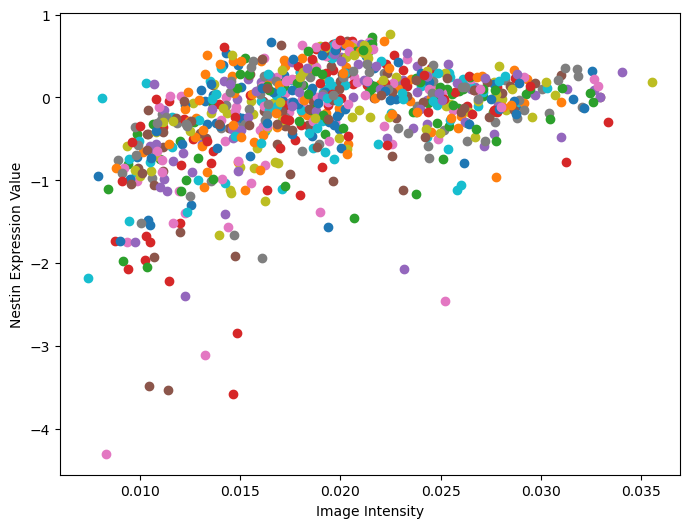

In [41]:
image_intensity = []
nestin_values =  y_train['NESTIN']

for i, image in enumerate(X_train):
    if(image.shape[-1] == 4):
        image = rgba2rgb(image) 
    I_hed = rgb2hed(image) 
    I_h = I_hed[:,:,0]
    image_intensity.append(np.mean(I_h))

plt.figure(figsize=(8, 6))
for i in range(800):
    plt.scatter(image_intensity[i], nestin_values[i])
    plt.xlabel('Image Intensity')
    plt.ylabel('Nestin Expression Value')
plt.show()

- Lower H Channel Intensity implies that there is a higher NESTIN expression value up to 0.025
- There are a few data points where the lower intensity gives a lower values of NESTIN

While the data does suggest that when the image intensity is higher there is more Nestin this is only true for some of the data as we do not have a strong linear relationshop in the data.

if we are to predict only NESTIN from the intensity we may have a higher intensity due to the lighter spots in the protein image but these could suggest that there are other expression types as well. Having a higher intesity does increase the chance that the protein expressions shown does include NESTIN. 

To use this as a method of predicting NESTIN we would need to consider the likelihood of other protein expressions being shown. Using methods like feature extraction may work better in this case, as the images are complex colours are not as distinctly separable, so a model using image intensity for predictions may not be as accurate.


**v. Performance Metrics for Prediction: Discuss suitable performance metrics for predicting protein expression from images. Identify the most appropriate metric for this specific problem and justify your choice.**

When dealing with protein expressions in images, we will need to consider that protein images are complex, it is hard to distinguish the proteins from the surrounding tissue, this noise makes it difficult to identify all expressions from a image. 

Let us consider the following Metrics:

Mean Sqaure Error (MSE):
When used on the images we will need to compare the actual and predicted protein expression values from the image. With feature extraction we can compare the actual and target values predicted making it a good model for regression tasks, more specifically due to the nature of our labels being continuous values. This approach is good as it not as affected by outliers like other performance metrics, using MAE can also be useful here as it too is not as affected by outliers.

Pearsons Correlation :
Pearsons correlation measures the linear correlation between data, in this case we are assuming that the images have a representation that is linearly correlated with the protein expression. For example the number of features from the image may indicate more of a protein expression. however as discussed in the specification, the tissue samples may have different number of expressions, while more features may indicate more protein expressions there is no guarantee that all expressions are present. the value of protein expressions can be dependant on other factors whether tissue is cancerous or not, these factors can affect how these are correlated making this a difficult performance metric to use.

Spearmans Correlation :
Spearmans correlation allows us to visualise the relationship between the image features and the protein expressions, having this understanding can be useful in visualisng how the number of features affects the protein expressions for all labels. With a small dataset spearmans correlation can be greatly affected, this can be true when we are taking a small sample for training to reduce computational load.

R^2:
R^2 can be a good model for evaluating how well a regression model performs, however it is important to note that the value of this will depend on the techniques used to gain information from an image. Tissue images are complex and have alot of noise so  this immediately will affect the accuracy of predicted values causing the overal R^2 to be affected.

Overall each of these metrics do not provide a well rounded performance metric alone, having information on all of the can  prove to be more useful however does MSE/RMSE provides one of the better ways to evaluate how well the model is performing with actual and target data, therefore allowing us understand the overall error in a models performance in detecting proteins.

# Question No. 2: (Feature Extraction and Classical Regression) 

### Feature Extraction with PCA


In [43]:
# Ordinary Least Squares (OLS) Regression Model:
# We will be defining the function to perform and plot the OLS Regressiob model here
# @PARAM: X_train,X_test,y_train,y_test
# @RETURN: None
def OLS(X_train,X_test,y_train,y_test):

    print('Ordinary Least Squares (OLS) Regression Model')
    
    #Set Linear Regression model and fit to training
    clf = LinearRegression(fit_intercept = True)
    clf.fit(X_train, y_train)

    #Predict using image Test data 
    y_pred = clf.predict(X_test)

    #plot scatter graphs for actual vs predicted
    plt.figure()
    for i in range(len(y_pred)):
        plt.scatter(y_pred[i], y_test[i])
        plt.xlabel('Predicted Value')
        plt.ylabel('Actual Value')
    mini = min(y_pred)
    maxi = max(y_pred)
    plt.plot([mini, maxi], [mini, maxi])
    plt.show()

    #print metrics
    mse = mean_squared_error(y_test, y_pred,squared=False)
    print("RMSE: ", np.sqrt(mse))
    correlation_coefficient, p_value = pearsonr(y_test,y_pred)
    print('Pearsons Correlation: ',correlation_coefficient, p_value)
    spearman = spearmanr(y_test,y_pred)
    print('Spearman Correlation Coefficient: ',spearman.statistic)
    r2 = r2_score(y_test,y_pred)
    print('R2 Score: ',r2)

In [50]:
#Support Vector Regression (SVR)

def SVRR(X_train,X_test,y_train,y_test):
    print('Support Vector Regression (SVR)')

    #Set SVR  model and fit to training
    params = {'kernel':['linear','poly','rbf'],'C': [0.1,1],}
    clf = SVR()
    #Use grid search to refine model parameters
    grid = GridSearchCV(estimator=clf,param_grid=params,verbose=0)


    model = grid.fit(X_train, y_train)
    
    #Predict using image Test data 

    y_pred = model.predict(X_test)

    #plot scatter graphs for actual vs predicted
    plt.figure()
    for i in range(len(y_pred)):
        plt.scatter(y_pred[i], y_test[i])
        plt.xlabel('Predicted Value')
        plt.ylabel('Actual Value')
    mini = min(y_pred)
    maxi = max(y_pred)
    plt.plot([mini, maxi], [mini, maxi])
    plt.show()

    #print metrics  
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE: ", np.sqrt(mse))
    correlation_coefficient, p_value = pearsonr(y_test,y_pred)
    print('Pearsons Correlation: ',correlation_coefficient, p_value)
    spearman = spearmanr(y_test,y_pred)
    print('Spearman Correlation Coefficient: ',spearman.statistic)
    r2 = r2_score(y_test,y_pred)
    print('R2 Score: ',r2)

In [45]:
def plot_feature(X_pca,target):
    
    #plots features extracted
    
    target = np.array(target)
    plt.scatter(X_pca[:,0], target)
    plt.xlabel('Feature Value')
    plt.ylabel('Target Value')
    plt.show()
        
    correlation_coefficient, p_value = pearsonr(X_pca[:, 0], target)
    print('Pearsons Correlation for first princple component: ',correlation_coefficient)


In [46]:
def convert_to_hed_pca(data):
    # function to split images into H,E,D Channels 
    
    all_images_h = []
    all_images_e = []
    all_images_d = []

    image_folder = './patches_256/'

    for image in data.index:
        image_path = image_folder + image  + '.png'
        I = imread(image_path)
        if(I.shape[-1] == 4):
            I = rgba2rgb(I) 
        I = rgb2hed(I)
        
        I_h = I[:,:,0]
        scaler = MinMaxScaler()
        I_h = scaler.fit_transform(I_h)
        I_h = I_h.flatten()
        all_images_h.append(I_h)

        I_e = I[:,:,1]
        scaler = MinMaxScaler()
        I_e = scaler.fit_transform(I_e)
        I_e = I_e.flatten()
        all_images_e.append(I_e)

        I_d = I[:,:,2]
        scaler = MinMaxScaler()
        I_d = scaler.fit_transform(I_d)
        I_d = I_d.flatten()
        all_images_d.append(I_d)
        
    return all_images_h,all_images_e,all_images_d

In [47]:
#PCA

train_data = []
test_data = []

#split test and train data 
training = new_data[new_data.specimen_id != 'C1']
test = new_data[new_data.specimen_id == 'C1']

labels = training[['NESTIN','cMYC','MET','specimen_id']]

train_h,train_e,train_d = convert_to_hed_pca(training)
test_h,test_e,test_d = convert_to_hed_pca(test)


PCA: H Channel
average_h 0.18827321517695073
variance_h 0.04039028312012386
[0.03170499 0.00524505 0.00464728 0.00396417 0.00386135 0.00345053
 0.00330462 0.00318856 0.00309037 0.00297891 0.00286518 0.00276684
 0.00268735 0.00266403 0.00254226]


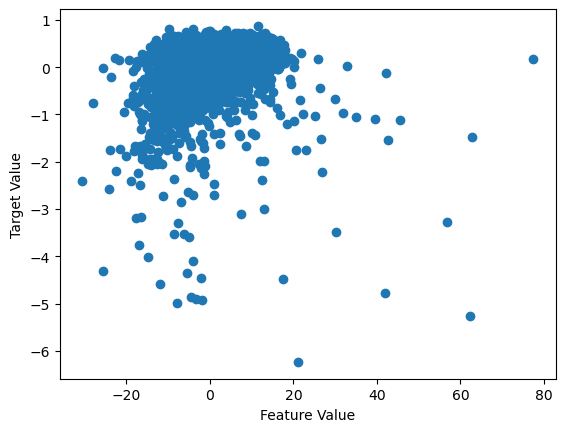

Pearsons Correlation for first princple component:  0.226367011048553
Support Vector Regression (SVR)


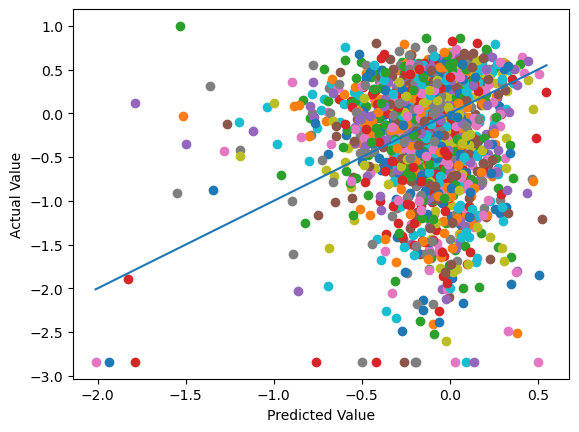

RMSE:  0.7301529666863442
Pearsons Correlation:  0.04752184877261151 0.055608127826432555
Spearman Correlation Coefficient:  0.043793461117188175
R2 Score:  -0.16607604125077158
Ordinary Least Squares (OLS) Regression Model


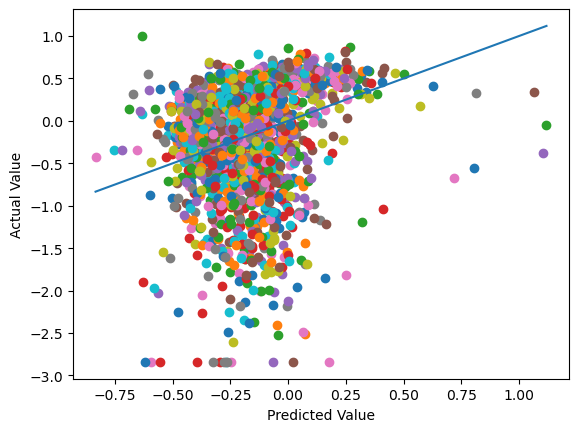

RMSE:  0.8225043748463696
Pearsons Correlation:  0.1696012934716551 6.1017579188637315e-12
Spearman Correlation Coefficient:  0.20281142905691552
R2 Score:  -0.0010413803345323824


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
print('PCA: H Channel')
ipca = IncrementalPCA(n_components=15, batch_size=100)

# print average and variance for H channel
print('average_h',np.mean(train_h))
print('variance_h',np.var(train_h))

#perform IPCA on test and train 
X_pca_h = ipca.fit_transform(train_h)
X_pca_h_test = ipca.fit_transform(test_h)

#Print explained varuance ration
print(ipca.explained_variance_ratio_)

#Plot Scatter plots
plot_feature(X_pca_h,labels['NESTIN'])

X_train, X_val, y_train, Y_val = train_test_split(X_pca_h, labels['NESTIN'], train_size=0.8, random_state=42)
SVRR(X_train,X_pca_h_test,y_train,test['NESTIN'])
OLS(X_train,X_pca_h_test,y_train,test['NESTIN'])

PCA: E Channel
average_e 0.32455621387359435
variance_e 0.047827494782638466
[0.05885564 0.01706043 0.01145562 0.00813545 0.00764876 0.00682487
 0.00622474 0.00577738 0.00557538 0.00506387 0.00470817 0.00459107
 0.00423034 0.00404914 0.00373471]


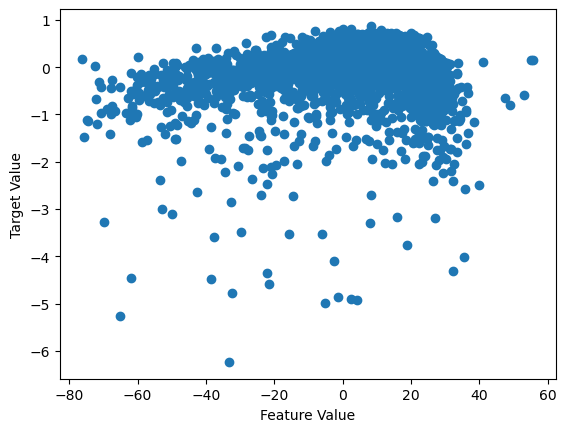

Pearsons Correlation for first princple component:  0.1154305504784842
[0.05885564 0.01706043 0.01145562 0.00813545 0.00764876 0.00682487
 0.00622474 0.00577738 0.00557538 0.00506387 0.00470817 0.00459107
 0.00423034 0.00404914 0.00373471]
Support Vector Regression (SVR)


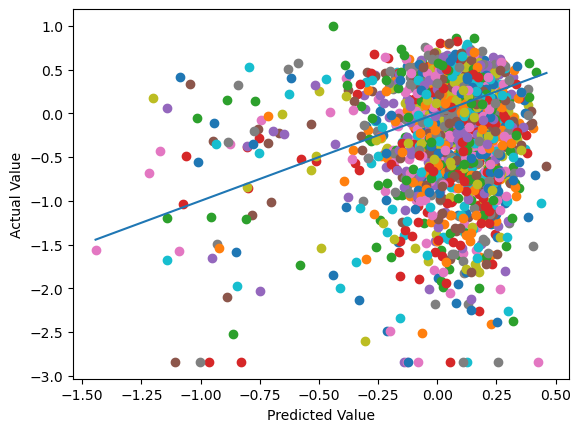

RMSE:  0.7510322863226415
Pearsons Correlation:  0.11610232394525825 2.7371727276854408e-06
Spearman Correlation Coefficient:  0.004819035059508451
R2 Score:  -0.2337193567698319
Ordinary Least Squares (OLS) Regression Model


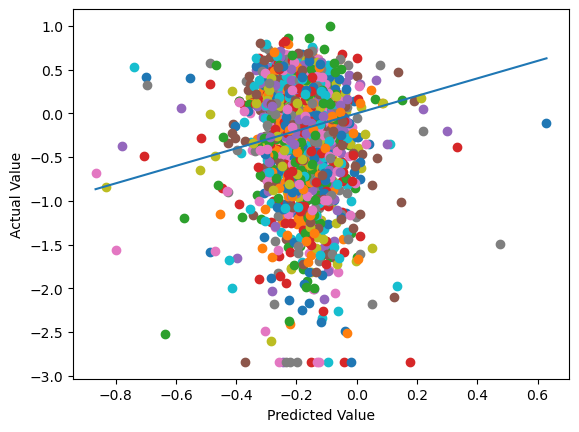

RMSE:  0.8358935196803636
Pearsons Correlation:  -0.0893787477242017 0.00031191537742738314
Spearman Correlation Coefficient:  -0.15323827913267518
R2 Score:  -0.06783216231813083


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [52]:
print('PCA: E Channel')
ipca = IncrementalPCA(n_components=15, batch_size=100)

# print average and variance for E channel
print('average_e',np.mean(train_e))
print('variance_e',np.var(train_e))

#perform IPCA on test and train 
X_pca_e = ipca.fit_transform(train_e)
X_pca_e_test = ipca.fit_transform(test_e)

#Print explained varuance ration
print(ipca.explained_variance_ratio_)

#plot scatter plots
plot_feature(X_pca_e,labels['NESTIN'])

X_train, X_val, y_train, Y_val = train_test_split(X_pca_e, labels['NESTIN'], train_size=0.8, random_state=42)
SVRR(X_train,X_pca_e_test,y_train,test['NESTIN'])
OLS(X_train,X_pca_e_test,y_train,test['NESTIN'])

PCA: D Channel
average_d 0.3785313873855666
variance_d 0.04902783037078976
[0.06082025 0.01777178 0.01125006 0.00809713 0.00785267 0.00698693
 0.00490221 0.00457516 0.00417297 0.00400116 0.0035915  0.00328699
 0.00320488 0.0026631  0.00259428]


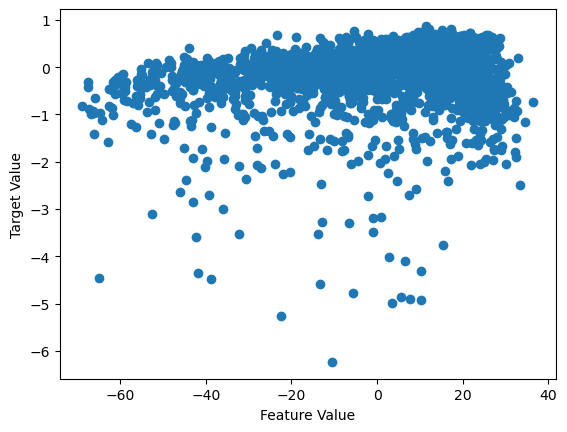

Pearsons Correlation for first princple component:  0.16107733398125978
[0.06082025 0.01777178 0.01125006 0.00809713 0.00785267 0.00698693
 0.00490221 0.00457516 0.00417297 0.00400116 0.0035915  0.00328699
 0.00320488 0.0026631  0.00259428]
Support Vector Regression (SVR)


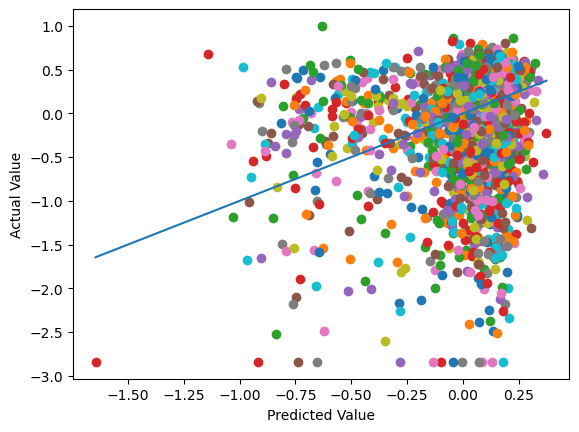

RMSE:  0.742356728384603
Pearsons Correlation:  0.0929340698582184 0.0001773871199264046
Spearman Correlation Coefficient:  0.05957143993654302
R2 Score:  -0.20538133492130095
Ordinary Least Squares (OLS) Regression Model


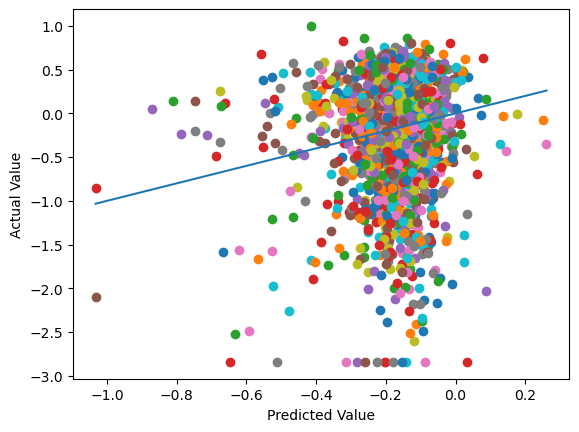

RMSE:  0.8273506924757904
Pearsons Correlation:  0.0567422904235815 0.022252649543823486
Spearman Correlation Coefficient:  0.018158637271757646
R2 Score:  -0.024843858479684844


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:
print('PCA: D Channel')
# pca = PCA(n_components = 3)
ipca = IncrementalPCA(n_components=15, batch_size=100)

# print average and variance for E channel
print('average_d',np.mean(train_d))
print('variance_d',np.var(train_d))

# Perform IPCA on test and train
X_pca_d = ipca.fit_transform(train_d)
X_pca_d_test = ipca.fit_transform(test_d)

#Print explained varuance ration
print(ipca.explained_variance_ratio_)

#plot scatter plots
plot_feature(X_pca_d,labels['NESTIN'])

X_train, X_val, y_train, Y_val = train_test_split(X_pca_d, labels['NESTIN'], train_size=0.8, random_state=42)
SVRR(X_train,X_pca_d_test,y_train,test['NESTIN'])
OLS(X_train,X_pca_d_test,y_train,test['NESTIN'])

## Feature Extraction with PCA

i) 

Applying PCA, such as randomized PCA or incremental PCA, can significantly reduce dimensionality while preserving the variance in the image data, making it easier to identify patterns. This is particularly useful for large datasets or high-resolution images where computational efficiency is a concern. We have chose to apply incremental PCA with 15 components and a batch size of 100. 

The overall correlation for our feature and target is shown to be low:

| Channel | Tranfer Learning for FeaturevsTarget |
|---------|------------------------------------------|
| H       | 0.2264  (4 d.p)                          | weak posotive correlation
| E       | 0.1154 (4 d.p)                           | weak posotive correlation
| D       | 0.1076  (4 d.p)                          | weak posotive correlation

Observations:
- H Channel has the highest correlation between features extracted and the target
- On all graphs data is highly clustered in one area showing there is little variance in the data.

The possible cause of this could be due to the random sample selected, however it is also important to consider that one spot can contain various protein expressions, so while some of the features extracted may be related to NESTIN, it could be possible that not all the features are NESTIN causing there to be a weak posotive correlation between the feature and target.


| Channel | Average             | Variance           |
|---------|---------------------|--------------------|
| H       | 0.1883  (4 d.p)     | 0.0404 (4 d.p)     | 
| E       | 0.3246 (4 d.p)      | 0.0478 (4 d.p)     | 
| D       | 0.3785  (4 d.p)     | 0.0490 (4 d.p)     | 


Moreover, when performing PCA we will also need to consider the ratios:

H Channel:

[0.03170499 0.00524505 0.00464728 0.00396417 0.00386135 0.00345053
 0.00330462 0.00318856 0.00309037 0.00297891 0.00286518 0.00276684
 0.00268735 0.00266403 0.00254226]

E Channel:

[0.05885564 0.01706043 0.01145562 0.00813545 0.00764876 0.00682487
 0.00622474 0.00577738 0.00557538 0.00506387 0.00470817 0.00459107
 0.00423034 0.00404914 0.00373471]

D Channel:
[0.06082025 0.01777178 0.01125006 0.00809713 0.00785267 0.00698693
 0.00490221 0.00457516 0.00417297 0.00400116 0.0035915  0.00328699
 0.00320488 0.0026631  0.00259428]

we can see PCA 0 for H channel we retain 3.17% of the original data, this low value indicates that we are losing information, similarly for the E and D Channels where we have 5.8%/6%. A possible cause of this is:

- Complexity of image - Protein images contain alot of noise making it hard to distinguish lighter areas
- PCA is a linear - We are assuming that the data has a linear relationship
- outliers - Data outliers, there might be higher protein expression in some images. This could be due to some causes that we arent aware of that affect the make-up.

One solution to this is joining all channels back together, this potentially can allow us to retain all features from the individual image while extracting features from each channel separately. 

ii)

SVR:

| Channel | RMSE             | Pearsons Correlation | Spearmans Correlation | R2 Score        |
|---------|------------------|----------------------|-----------------------|-----------------|
| H       | 0.7302 (4 d.p)   | 0.0475 (4 d.p)       | 0.0438 (4 d.p)        | -0.1661 (4 d.p) |
| E       | 0.7510 (4 d.p)   | 0.1161 (4 d.p)       | 0.0048 (4 d.p)        | -0.2337 (4 d.p) |
| D       | 0.7424  (4 d.p)  | 0.0929 (4 d.p)       | 0.0596 (4 d.p)        | -0.2053 (4 d.p) |

OLS:


| Channel | RMSE            | Pearsons Correlation | Spearmans Correlation | R2 Score        |
|---------|-----------------|----------------------|-----------------------|-----------------|
| H       | 0.8225 (4 d.p)  | 0.1696 (4 d.p)       | 0.2028 (4 d.p)        | -0.0010 (4 d.p) |
| E       | 0.8359 (4 d.p)  | -0.0893 (4 d.p)      | -0.1532 (4 d.p)       | -0.0678 (4 d.p) |
| D       | 0.8273 (4 d.p)  | 0.0567 (4 d.p)       | 0.0181 (4 d.p)        | -0.0248 (4 d.p) |


Scatter plots are shown in cells above.

Note: Increasing sample size may affect results.

### Feature Extraction with Transfer Learning

In [54]:

def convert_to_hed_tl(data):
    all_images_h = []
    all_images_e = []
    all_images_d = []

    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model =list(model.children())[:-1]
    model=nn.Sequential(*model)

    for p in model.parameters():
        p.requires_grad = False

    for image in data.index:
        image_path = image_folder + image  + '.png'

        I = imread(image_path)
        if(I.shape[-1] == 4):
            I = rgba2rgb(I) 
        I = rgb2hed(I) 
        I_h = I[:,:,0]
        #https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images
        #RESNET model requires a 3 channel image as we are using a pretrained model
        I_h = np.repeat(I_h[..., np.newaxis], 3, -1)
        # print(I_h.shape)
        transform = transforms.Compose([transforms.ToTensor()])
        I_h = transform(I_h).float()
        I_h = torch.unsqueeze(I_h, 0)
        I_h = model(I_h)
        I_h = I_h.flatten()
        all_images_h.append(I_h)

        I_e = I[:,:,1]
        I_e = np.repeat(I_e[..., np.newaxis], 3, -1)
        transform = transforms.Compose([transforms.ToTensor()])
        I_e = transform(I_e).float()
        I_e = torch.unsqueeze(I_e, 0)
        I_e = model(I_e)
        I_e = I_e.flatten()
        all_images_e.append(I_e)

        I_d = I[:,:,1]
        I_d = np.repeat(I_d[..., np.newaxis], 3, -1)
        transform = transforms.Compose([transforms.ToTensor()])
        I_d = transform(I_d).float()
        I_d = torch.unsqueeze(I_d, 0)
        I_d = model(I_d)
        I_d = I_d.flatten()
        all_images_d.append(I_d)

    return all_images_h,all_images_e,all_images_d

In [55]:
#Transfer Learning

#developed using https://discuss.pytorch.org/t/how-can-l-use-the-pre-trained-resnet-to-extract-feautres-from-my-own-dataset/9008


train_data = []
test_data = []

training = new_data[new_data.specimen_id != 'C1']
test = new_data[new_data.specimen_id == 'C1']

labels = training[['NESTIN','cMYC','MET','specimen_id']]

train_h,train_e,train_d = convert_to_hed_tl(training)
test_h,test_e,test_d = convert_to_hed_tl(test)



average_h 0.07588431
variance_h 0.0060625267


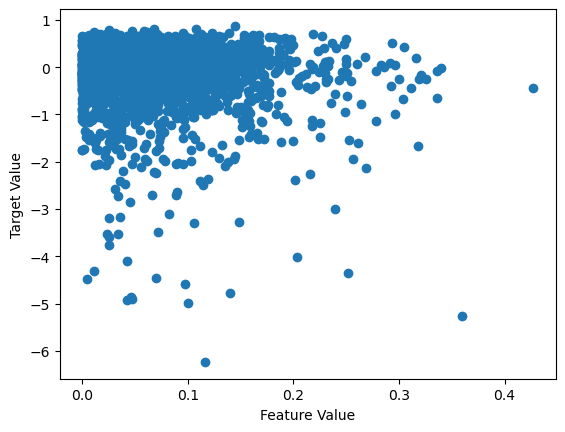

Pearsons Correlation for first princple component:  -0.08608112761818293
Support Vector Regression (SVR)


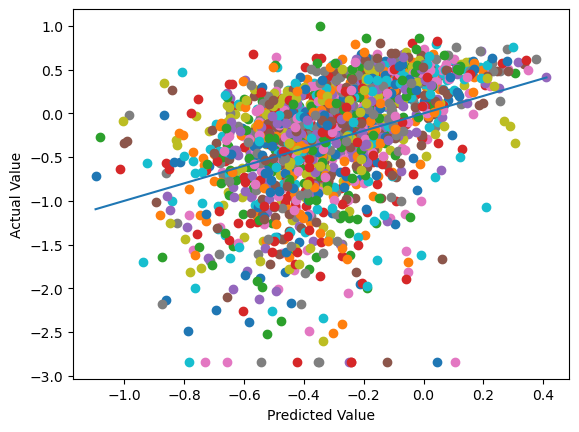

RMSE:  0.6076283045398096
Pearsons Correlation:  0.45427876990200916 1.9030111874775016e-83
Spearman Correlation Coefficient:  0.5252416103204218
R2 Score:  0.19243933704508265
Ordinary Least Squares (OLS) Regression Model


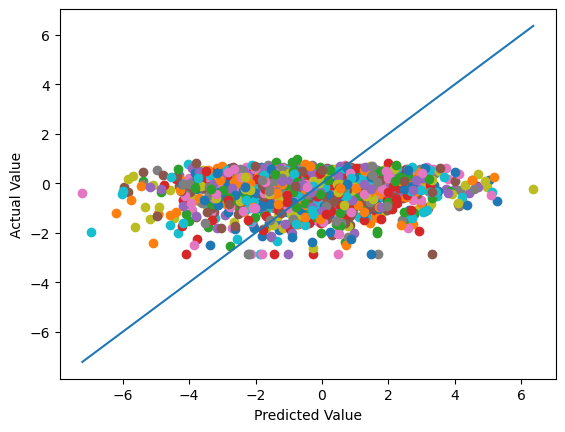

RMSE:  1.4492594734757176
Pearsons Correlation:  0.09971093066356469 5.723290034203186e-05
Spearman Correlation Coefficient:  0.08540383541418792
R2 Score:  -8.649032200023765


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
all_images_h  = np.stack([tensor.squeeze().numpy() for tensor in train_h])
all_images_h_test  = np.stack([tensor.squeeze().numpy() for tensor in test_h])
labels_test = test[['NESTIN','cMYC','MET','specimen_id']]


# print average and variance for h channel
print('average_h',np.mean(all_images_h))
print('variance_h',np.var(all_images_h))

plot_feature(all_images_h,labels['NESTIN'])

X_train, X_val, y_train, y_val = train_test_split(all_images_h, labels['NESTIN'], train_size=0.8, random_state=42)

SVRR(X_train,all_images_h_test,y_train,labels_test['NESTIN'])
OLS(X_train,all_images_h_test,y_train,labels_test['NESTIN'])

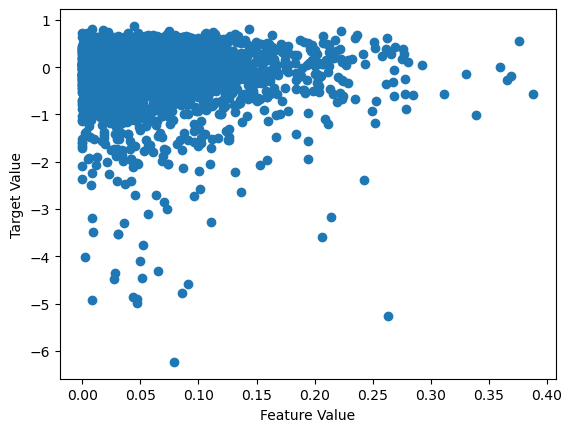

Pearsons Correlation for first princple component:  0.00022718548349590258
average_e 0.07694903
variance_e 0.0063824854
Support Vector Regression (SVR)


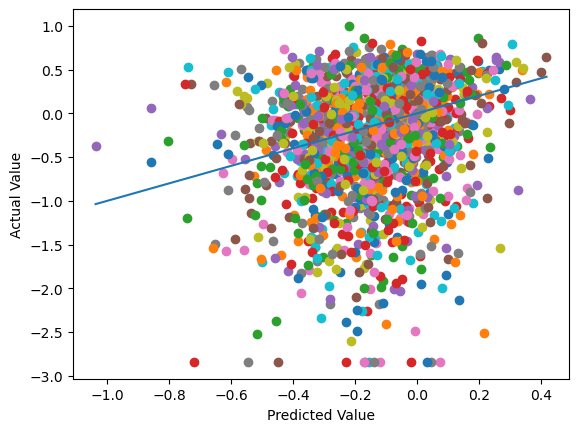

RMSE:  0.6790468268281953
Pearsons Correlation:  0.1745209290729449 1.4434797005609121e-12
Spearman Correlation Coefficient:  0.1947822956562309
R2 Score:  -0.008552736690423224
Ordinary Least Squares (OLS) Regression Model


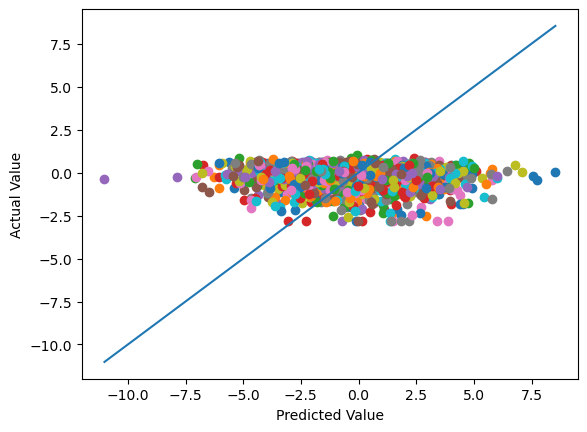

RMSE:  1.5753021602981916
Pearsons Correlation:  -0.04423213538263794 0.07483802657630759
Spearman Correlation Coefficient:  -0.03700154469815082
R2 Score:  -12.469598120092368


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
all_images_e  = np.stack([tensor.squeeze().numpy() for tensor in train_e])
all_images_e_test  = np.stack([tensor.squeeze().numpy() for tensor in test_e])
labels_test = test[['NESTIN','cMYC','MET','specimen_id']]

plot_feature(all_images_e,labels['NESTIN'])

# print average and variance for e channel
print('average_e',np.mean(all_images_e))
print('variance_e',np.var(all_images_e))

X_train, X_val, y_train, y_val = train_test_split(all_images_e, labels['NESTIN'], train_size=0.8, random_state=42)

SVRR(X_train,all_images_e_test,y_train,labels_test['NESTIN'])
OLS(X_train,all_images_e_test,y_train,labels_test['NESTIN'])

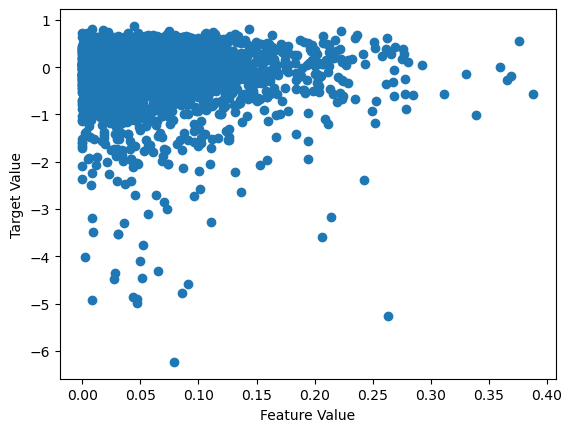

Pearsons Correlation for first princple component:  0.00022718548349590258
average_d 0.07694903
variance_d 0.0063824854
Support Vector Regression (SVR)


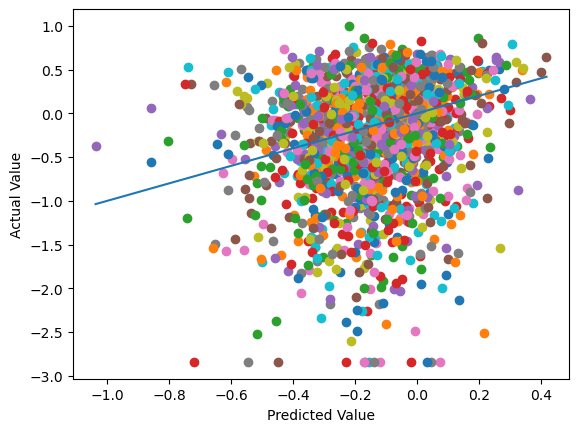

RMSE:  0.6790468268281953
Pearsons Correlation:  0.1745209290729449 1.4434797005609121e-12
Spearman Correlation Coefficient:  0.1947822956562309
R2 Score:  -0.008552736690423224
Ordinary Least Squares (OLS) Regression Model


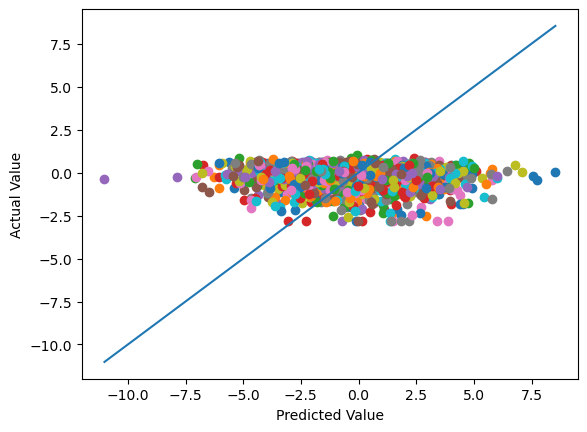

RMSE:  1.5753021602981916
Pearsons Correlation:  -0.04423213538263794 0.07483802657630759
Spearman Correlation Coefficient:  -0.03700154469815082
R2 Score:  -12.469598120092368


c:\Users\Priya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [61]:
all_images_d = np.stack([tensor.squeeze().numpy() for tensor in train_d])
all_images_d_test  = np.stack([tensor.squeeze().numpy() for tensor in test_d])
labels_test = test[['NESTIN','cMYC','MET','specimen_id']]

plot_feature(all_images_d,labels['NESTIN'])

# print average and variance for d channel
print('average_d',np.mean(all_images_d))
print('variance_d',np.var(all_images_d))

X_train, X_val, y_train, y_val = train_test_split(all_images_d, labels['NESTIN'], train_size=0.8, random_state=42)

SVRR(X_train,all_images_d_test,y_train,labels_test['NESTIN'])
OLS(X_train,all_images_d_test,y_train,labels_test['NESTIN'])

## Feature Extraction with Transfer Learning

i) 

Utilizing a pre-trained neural network to extract feature embeddings can leverage learned patterns from vast datasets, potentially improving your model's ability to generalize from the visual content of the images. However in this case we are using a pretrained RESNET model when extracting our features.

The overall correlation for our feature and target is shown to be low:

| Channel | Pearsons Correlation for FeaturevsTarget |
|---------|------------------------------------------|
| H       | -0.0861  (4 d.p)                         | weak negative correlation
| E       |  0.0002 (4 d.p)                           | weak posotive correlation
| D       | 0.1456  (4 d.p)                          | weak posotive correlation

Observations:
- H Channel unlike PCA has the lowest correlation
- low correlation across all channels

The main problem with this is that resnet performs well on a multi channel image dataset, for tasks similar to this. When we use RESNET on a single channel we lose alot of information, as the model is pretrained, when we feed images that are not in the correct format the model cannot adapt to these changes leading there to be poor results. #

As RESNET does not take a single channel image we have we have created a image with 3 channels of the same channel x3.


| Channel | Average             | Variance           |
|---------|---------------------|--------------------|
| H       | 0.0758  (4 d.p)     | 0.0061 (4 d.p)     | 
| E       | 0.0769 (4 d.p)      | 0.0063 (4 d.p)     | 
| D       | 0.0769  (4 d.p)     | 0.0064 (4 d.p)     | 


Compared to PCA this transfer learning does not work as well due to the nature of pretrained models using 3 channel images. If we still wish to use a pretrained model it may be better to use the images in their original form. However this too can be difficult as protein images are highly complex making it difficult to extract data from images like this. This method does not provide the best set of feature extracted.

ii)

SVR:

| Channel | RMSE             | Pearsons Correlation | Spearmans Correlation | R2 Score        |
|---------|------------------|----------------------|-----------------------|-----------------|
| H       | 0.6076 (4 d.p)   | 0.4542 (4 d.p)       | 0.5252 (4 d.p)        | 0.1924 (4 d.p)  |
| E       | 0.6790 (4 d.p)   | 0.1745 (4 d.p)       | 0.1947 (4 d.p)        | -0.0086 (4 d.p) |
| D       | 0.6790  (4 d.p)  |  0.1745 (4 d.p)      | 0.1948 (4 d.p)        | -0.0086 (4 d.p) |

OLS:


| Channel | RMSE            | Pearsons Correlation | Spearmans Correlation | R2 Score        |
|---------|-----------------|----------------------|-----------------------|-----------------|
| H       | 1.4491 (4 d.p)  | 0.0997 (4 d.p)       | 0.0854 (4 d.p)        | -8.6490 (4 d.p) |
| E       | 1.5753 (4 d.p)  | -0.0442 (4 d.p)      | -0.0370 (4 d.p)       |-12.4695 (4 d.p) |
| D       | 1.5753 (4 d.p)  | -0.0442 (4 d.p)      | -0.0370 (4 d.p)       |-12.4696 (4 d.p) |


Scatter plots are shown in cells above.

Note: Increasing sample size may affect results.

# Question No. 3 (Using Convolutional Neural Networks) 

### (i) 

In [62]:
train_data = []
test_data = []

training = new_data[new_data.specimen_id != 'C1']
test = new_data[new_data.specimen_id == 'C1']

#Store images in array that are in sample in all_images array

for image in training.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    if(I.shape[-1] == 4):
        I = rgba2rgb(I)
    I = rgb2hed(I)
    train_data.append(I)

for image in test.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    if(I.shape[-1] == 4):
        I = rgba2rgb(I)
    I = rgb2hed(I)
    test_data.append(I)

# Split data into test and train

X_train, X_val, y_train, y_val = train_test_split(train_data, np.array(training[['NESTIN']]), train_size=0.8, random_state=42)
X_test = test_data
y_test = np.array(test[['NESTIN']])


Epoch [1/5], Loss: 0.4789
Epoch [2/5], Loss: 0.4519
Epoch [3/5], Loss: 0.4105
Epoch [4/5], Loss: 0.4046
Epoch [5/5], Loss: 0.3952
Mean Squared Error on the test set: 0.4931


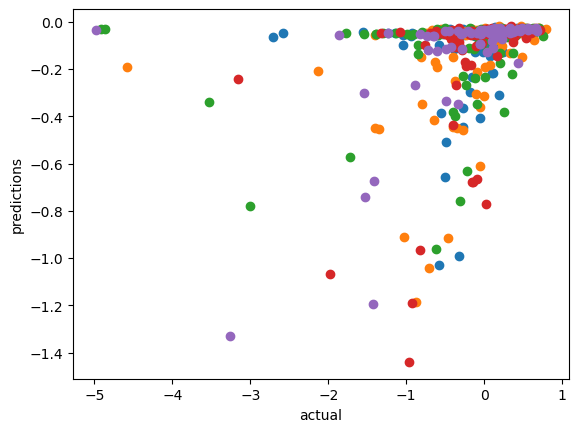

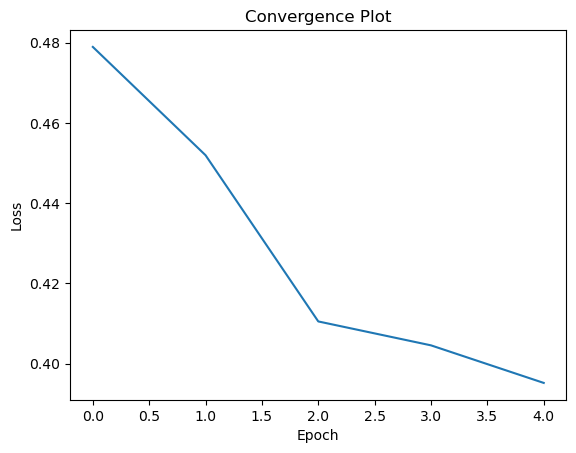

RMSE:  0.6988543
Pearsons Correlation:  0.3092542909197608
Spearman Correlation Coefficient:  0.45514173891999704
R2 Score:  0.08742496114920739


In [66]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Convert data into tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_val,dtype=torch.float32)
y_test_tensor = torch.tensor(y_val,dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

# Create CNN model ( This model has 3 layers with 1 output - the value predicted value for NESTIN)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(64 * 32 * 32, 1)  

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()
convergence_loss = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.permute(0, 3, 2, 1)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    convergence_loss.append(epoch_loss)

    if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Evaluate Model created on test data       
model.eval()
# Saving predictions and actual values in array for plotting
predictions = []
actual = []
with torch.no_grad():
    total_mse = 0.0
    for images, labels in test_loader:
        images = images.permute(0, 3, 2, 1)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions.append(outputs)
        actual.append(labels)
        
        mse = criterion(outputs, labels).item()
        total_mse += mse
    avg_mse = total_mse / len(test_loader)
    print('Mean Squared Error on the test set: {:.4f}'.format(avg_mse))

#Plot scatter graphs and format data for metrics

actual_data = []
prediction_data = []
for i in range(len(predictions)):
    actual[i] = np.array(actual[i])
    predictions[i] = np.array(predictions[i])
    plt.scatter(actual[i],predictions[i])
    plt.xlabel('actual')
    plt.ylabel('predictions')
    actual_data.append(actual[i].flatten())
    prediction_data.append(predictions[i].flatten())

plt.show()
actual_data = np.hstack(actual_data)
prediction_data= np.hstack(prediction_data)

# Plot loss per epoch
plt.plot(convergence_loss)
plt.title('Convergence Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Print metrics  
mse = mean_squared_error(actual_data, prediction_data) #updated in summary table with root value
print("RMSE: ", np.sqrt(mse))
correlation_coefficient, p_value = pearsonr(actual_data, prediction_data)
print('Pearsons Correlation: ',correlation_coefficient)
spearman = spearmanr(actual_data, prediction_data)
print('Spearman Correlation Coefficient: ',spearman.statistic)
r2 = r2_score(actual_data, prediction_data)
print('R2 Score: ',r2)

### Summary of Results on test data

Metrics:

|                       |        |
|-----------------------|--------|
| RMSE                  | 0.6989 |
| Pearsons Correlation  | 0.3093 |
| Spearmans Correlation | 0.4551 |
| R2 Score              | 0.0874 |

Loss Per Epoch:

| Epoch | Loss   |
|-------|--------|
| 1     | 0.4789 |
| 2     | 0.4519 |
| 3     | 0.4105 |
| 4     | 0.4046 |
| 5     | 0.3952 |

### (ii) 

In [200]:
#function used to print metrics 

def print_metric(actual_data,prediction_data):
    # Print metrics  
    mse = mean_squared_error(actual_data, prediction_data) #updated in summary table with root value
    print("RMSE: ", mse)
    correlation_coefficient, p_value = pearsonr(actual_data, prediction_data)
    print('Pearsons Correlation: ',correlation_coefficient)
    spearman = spearmanr(actual_data, prediction_data)
    print('Spearman Correlation Coefficient: ',spearman.statistic)
    r2 = r2_score(actual_data, prediction_data)
    print('R2 Score: ',r2)
    
#function used to plot each specimens data
def plot_scatter_by_group(specimen,predictions,actual):
    
    EGFR = []
    PTEN = []
    NESTIN = []
    SOX2 = []
    MET = []

    actual_EGFR = []
    actual_PTEN = []
    actual_NESTIN = []
    actual_SOX2 = []
    actual_MET = []


    for pred in predictions:
        for j in range(len(pred)):
            EGFR.append(pred[j][0].item())
            PTEN.append(pred[j][1].item())
            NESTIN.append(pred[j][3].item())
            SOX2.append(pred[j][2].item())
            MET.append(pred[j][4].item())

    for act in actual:
        for j in range(len(act)):
            actual_EGFR.append(act[j][0].item())
            actual_PTEN.append(act[j][1].item())
            actual_NESTIN.append(act[j][3].item())
            actual_SOX2.append(act[j][2].item())
            actual_MET.append(act[j][4].item())


    plt.scatter(EGFR,actual_EGFR)
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title(specimen + ': EGFR - Actual vs Predicted Data')
    plt.show()

    print_metric(EGFR,actual_EGFR)

    plt.scatter(PTEN,actual_PTEN)
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title(specimen + ': PTEN - Actual vs Predicted Data')
    plt.show()

    print_metric(PTEN,actual_PTEN)

    plt.scatter(NESTIN,actual_NESTIN)
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title(specimen + ': NESTIN - Actual vs Predicted Data')
    plt.show()

    print_metric(NESTIN,actual_NESTIN)

    plt.scatter(SOX2,actual_SOX2)
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title(specimen + ': SOX2 - Actual vs Predicted Data')
    plt.show()

    print_metric(SOX2,actual_SOX2)

    plt.scatter(MET,actual_MET)
    plt.xlabel('actual')
    plt.ylabel('predictions')
    plt.title(specimen + ': MET - Actual vs Predicted Data')
    plt.show()

    print_metric(MET,actual_MET)


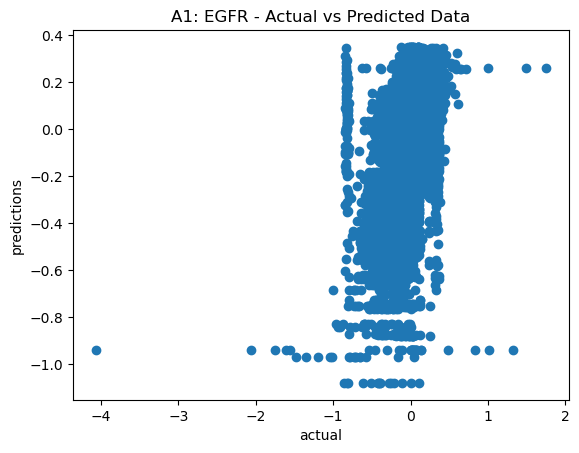

RMSE:  0.04207150846943888
Pearsons Correlation:  0.42520973210134255
Spearman Correlation Coefficient:  0.4066593900362008
R2 Score:  -0.6360950166104862


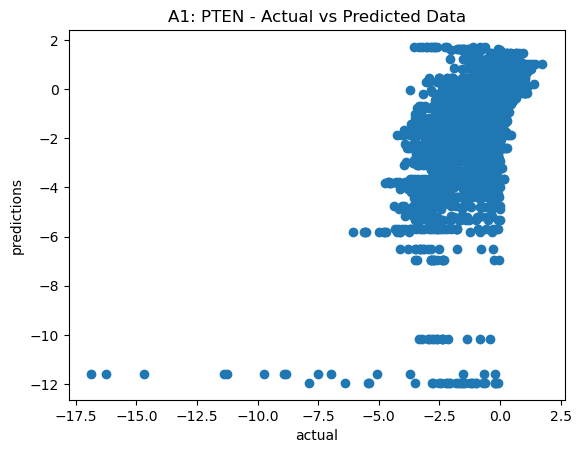

RMSE:  0.8939903637626001
Pearsons Correlation:  0.656756646287179
Spearman Correlation Coefficient:  0.5198584853373531
R2 Score:  -0.40360564014560185


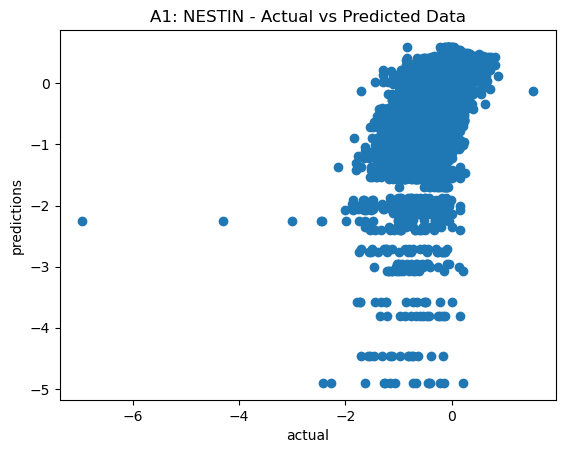

RMSE:  0.1762627734750062
Pearsons Correlation:  0.5315715158716405
Spearman Correlation Coefficient:  0.4194364664740371
R2 Score:  -1.1673162741335394


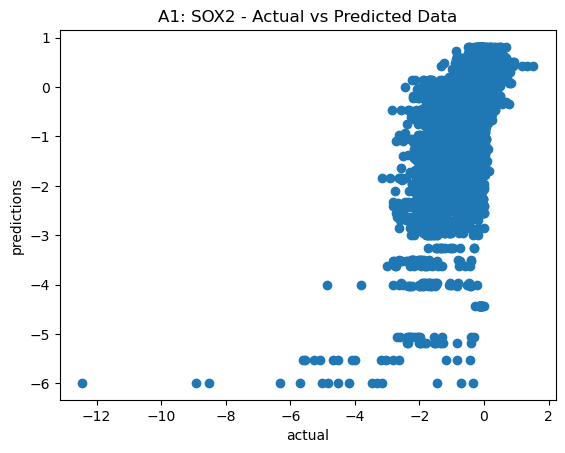

RMSE:  0.37449624687027955
Pearsons Correlation:  0.6239937382868364
Spearman Correlation Coefficient:  0.5103957010943061
R2 Score:  -0.517000646546085


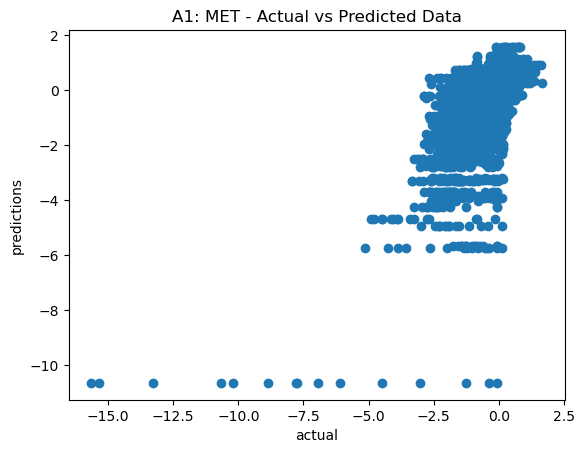

RMSE:  0.427843009656432
Pearsons Correlation:  0.6770045533141731
Spearman Correlation Coefficient:  0.5480932173835904
R2 Score:  -0.18715434084701554


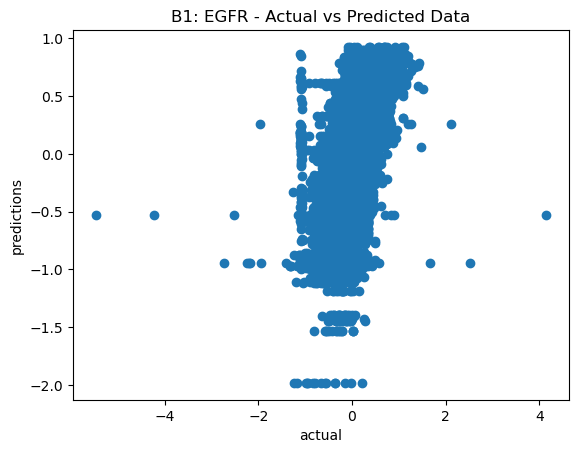

RMSE:  0.11559612981208083
Pearsons Correlation:  0.5506104369707802
Spearman Correlation Coefficient:  0.5422543425773548
R2 Score:  -0.5070900984946984


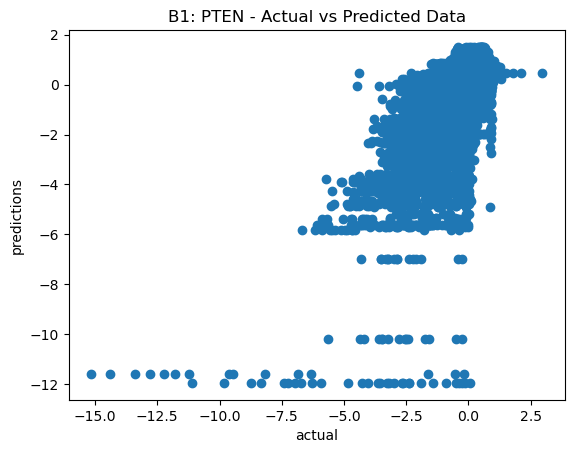

RMSE:  0.7105074239878525
Pearsons Correlation:  0.6896590017535156
Spearman Correlation Coefficient:  0.5407680375611577
R2 Score:  -0.15964655525969396


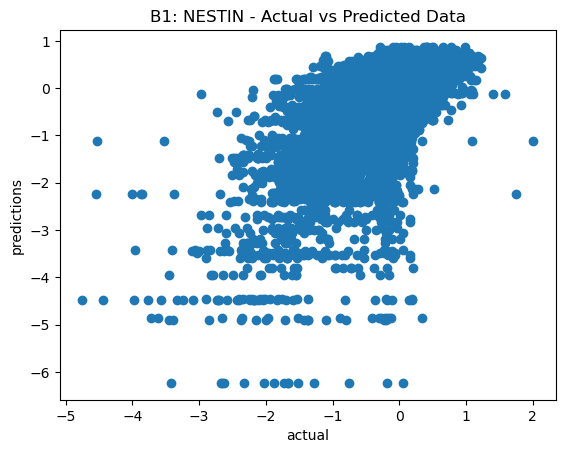

RMSE:  0.32983257968477203
Pearsons Correlation:  0.6241305979462786
Spearman Correlation Coefficient:  0.5791687291784878
R2 Score:  -0.44184613222785174


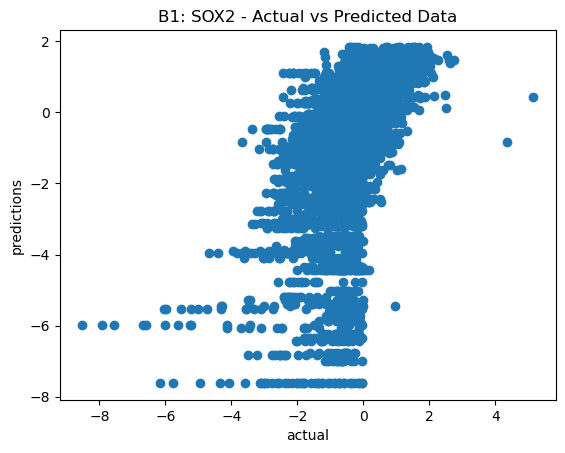

RMSE:  0.876216361154982
Pearsons Correlation:  0.5462213973802519
Spearman Correlation Coefficient:  0.5486394469930487
R2 Score:  -1.4392360042140662


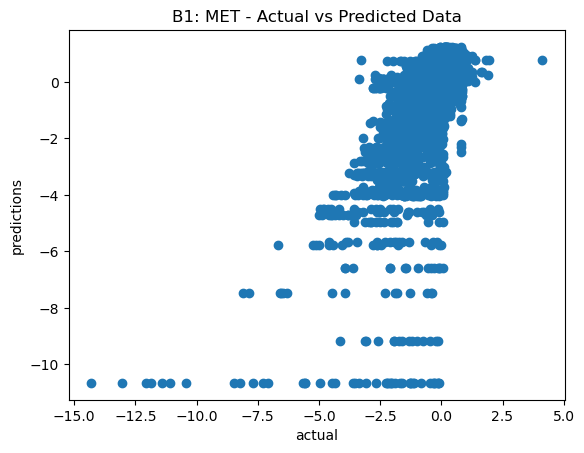

RMSE:  0.48093857823633096
Pearsons Correlation:  0.6466075175986314
Spearman Correlation Coefficient:  0.37837134938939826
R2 Score:  -0.45796335763253104


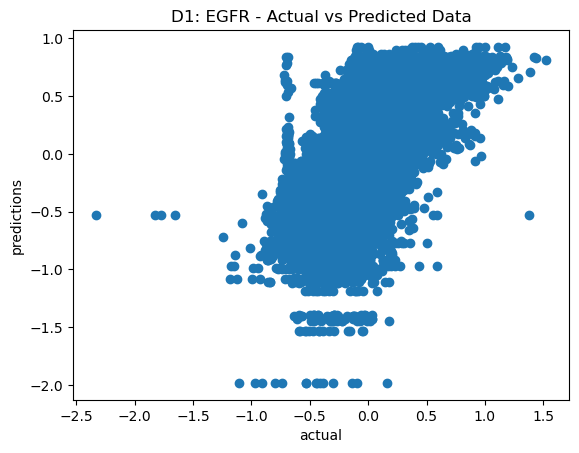

RMSE:  0.08912697780858349
Pearsons Correlation:  0.6273062770077237
Spearman Correlation Coefficient:  0.6247032093467192
R2 Score:  -0.24959187956811868


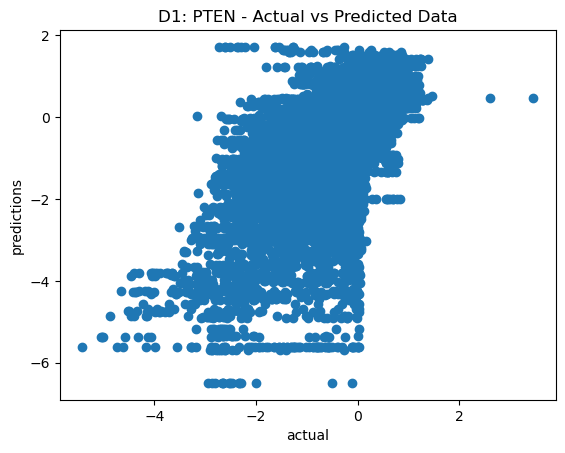

RMSE:  0.6241162022584767
Pearsons Correlation:  0.6898288905060228
Spearman Correlation Coefficient:  0.6304469849912968
R2 Score:  -0.18093762379504152


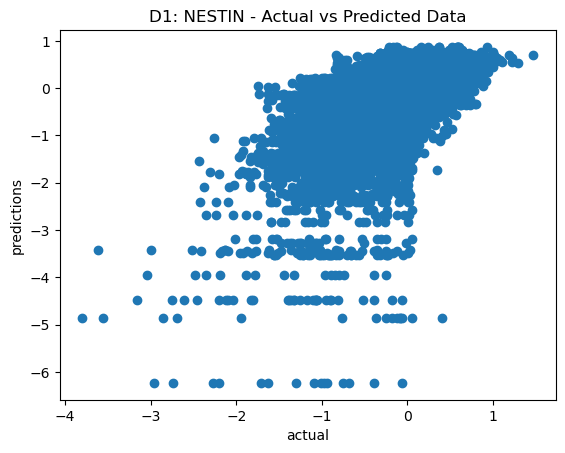

RMSE:  0.2573878016089197
Pearsons Correlation:  0.6279357258187179
Spearman Correlation Coefficient:  0.6261359700783227
R2 Score:  -0.5244692247654024


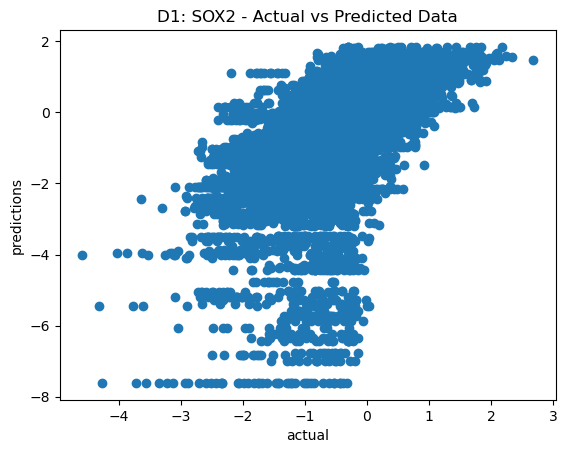

RMSE:  0.7884342781528496
Pearsons Correlation:  0.580343868101974
Spearman Correlation Coefficient:  0.6414762625404941
R2 Score:  -1.1075365173474276


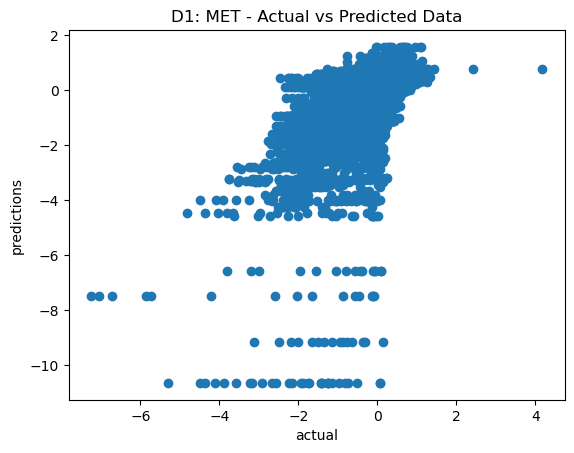

RMSE:  0.4318814576331329
Pearsons Correlation:  0.6513838845119824
Spearman Correlation Coefficient:  0.5560451340490776
R2 Score:  -0.4667472007113025
Mean Squared Error on the test set: 0.6205


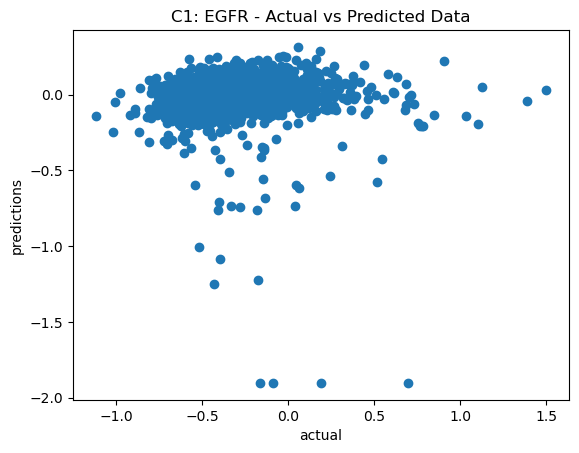

RMSE:  0.2096860290303025
Pearsons Correlation:  0.07806392955420997
Spearman Correlation Coefficient:  0.2898289845620638
R2 Score:  -1.4720127189639198


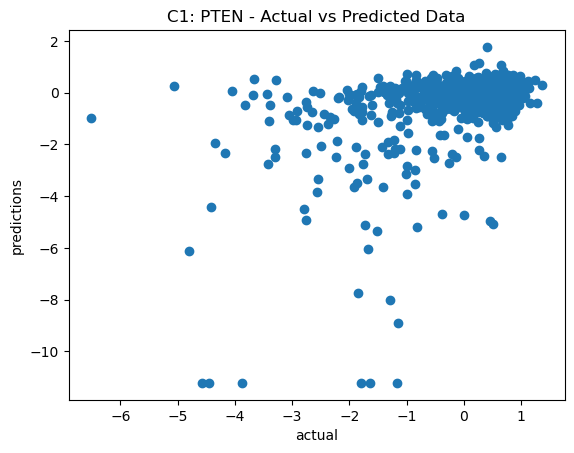

RMSE:  1.0742115674367416
Pearsons Correlation:  0.4532543428374109
Spearman Correlation Coefficient:  0.07898101467999853
R2 Score:  -0.6317967328354217


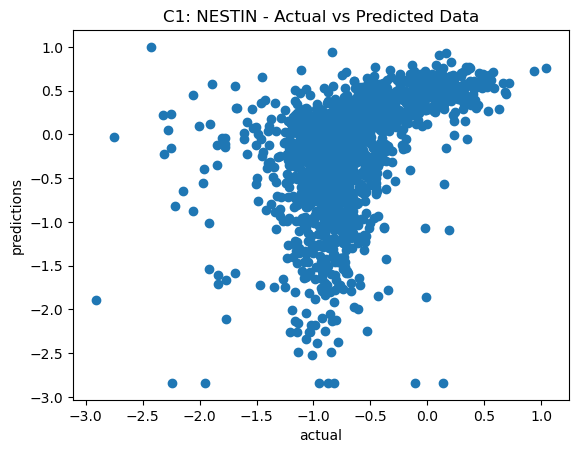

RMSE:  0.5706971921532658
Pearsons Correlation:  0.4547106157041859
Spearman Correlation Coefficient:  0.5205332296314195
R2 Score:  -1.74728450123673


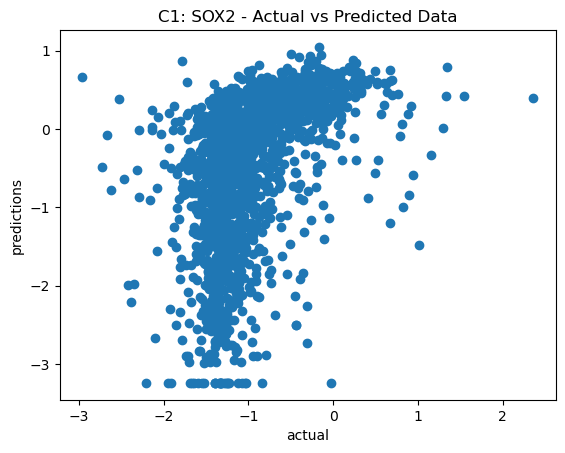

RMSE:  0.964166058791201
Pearsons Correlation:  0.4484630940706952
Spearman Correlation Coefficient:  0.5435155966468148
R2 Score:  -2.1828054643258916


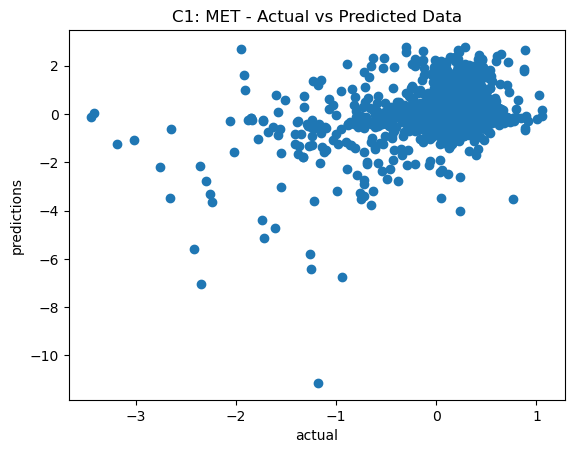

RMSE:  0.8147052302956262
Pearsons Correlation:  0.3484535893603621
Spearman Correlation Coefficient:  0.2159258089930359
R2 Score:  -2.2859636594464523


In [208]:
train_data = []
test_data = []

training = new_data[new_data.specimen_id != 'C1']
test = new_data[new_data.specimen_id == 'C1']
#Store images in array that are in sample in all_images array
specimen_type = ['A1','B1','D1']
for image in training.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    if(I.shape[-1] == 4):
        I = rgba2rgb(I)
    I = rgb2hed(I)
    train_data.append(I)

for image in test.index:
    image_path = image_folder + image  + '.png'
    I = imread(image_path)
    if(I.shape[-1] == 4):
        I = rgba2rgb(I)
    I = rgb2hed(I)
    test_data.append(I)


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#EGFR, PTEN, NESTIN, SOX2, and MET
# parameters
num_epochs = 15
batch_size = 100
learning_rate = 0.001

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(64 * 32 * 32, 6)  # 6 outputs for each label last label (specimen) is ignored for plotting

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out



# Loss and optimizer
train_data = np.array(train_data)
groups = training.specimen_id
training = training.reset_index(drop=True)
training = training.drop(columns=['cMYC'])
test = test.reset_index(drop=True)
test = test.drop(columns=['cMYC'])
# groups_encoded = label_encoder.fit_transform(groups)

#, employ a "leave one specimen out cross-validation" strategy
group_kfold = GroupKFold(n_splits=len(groups.unique()))
label_encoder = LabelEncoder()


training.specimen_id = label_encoder.fit_transform(training.specimen_id)
test.specimen_id = label_encoder.fit_transform(test.specimen_id)

for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, training, groups)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}, group={groups[train_index]}")
    # print(f"  Test:  index={test_index}, group={groups[test_index]}")
    predictions = []
    actual = []

    X_train, X_val = train_data[train_index], train_data[test_index]
    y_train, y_val = training.iloc[train_index], training.iloc[test_index]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    train_loader =DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True)


    model = ConvNet().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # # Train the model
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for j, (images, labels) in enumerate(train_loader):
            images = images.permute(0, 3, 2, 1)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            predictions.append(outputs)
            actual.append(labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)


    plot_scatter_by_group(specimen_type[i],predictions,actual)

#load test data

X_test_tensor = torch.tensor(test_data,dtype=torch.float32)
y_test_tensor = torch.tensor(test.values,dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(dataset=test_dataset,
                    batch_size=batch_size,
                    shuffle=False) 

#Evaluate model on test
model.eval()
predictions = []
actual = []
with torch.no_grad():
    total_mse = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.permute(0, 3, 2, 1)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions.append(outputs)
        actual.append(labels)
        
        mse = criterion(outputs, labels).item()
        total_mse += mse
    avg_mse = total_mse / len(test_loader)
    print('Mean Squared Error on the test set: {:.4f}'.format(avg_mse))

plot_scatter_by_group('C1',predictions,actual)



Summary of Results:

SPECIMEN A1

|                       | EFGR    | PTEN    | NESTIN  | SOX2    | MET     |
|-----------------------|---------|---------|---------|---------|---------|
| RMSE                  | 0.2051  | 0.9455  | 0.4199  | 0.6120  | 0.6541  |
| Pearsons Correlation  | 0.4252  | 0.6568  | 0.5316  | 0.6240  | 0.6770  |
| Spearmans Correlation | 0.4067  | 0.5199  | 0.4194  | 0.5104  | 0.5481  |
| R2 Score              | -0.6361 | -0.4036 | -1.1673 | -0.5170 | -0.1872 |


SPECIMEN B1

|                       | EFGR    | PTEN    | NESTIN  | SOX2    | MET     |
|-----------------------|---------|---------|---------|---------|---------|
| RMSE                  | 0.3340  | 0.7105  | 0.8429  | 0.9360  | 0.6935  |
| Pearsons Correlation  | 0.5506  | 0.6897  | 0.6241  | 0.5462  | 0.6466  |
| Spearmans Correlation | 0.5423  | 0.5408  | 0.5792  | 0.5486  | 0.3784  |
| R2 Score              | -0.5071 | -0.1596 | -0.4418 | -1.4392 | -0.4580 |


SPECIMEN D1

|                       | EFGR    | PTEN    | NESTIN  | SOX2    | MET     |
|-----------------------|---------|---------|---------|---------|---------|
| RMSE                  | 0.2984  | 0.7900  | 0.2574  | 0.5073  | 0.6571  |
| Pearsons Correlation  | 0.6273  | 0.6898  | 0.6279  | 0.5803  | 0.6514  |
| Spearmans Correlation | 0.6247  | 0.6304  | 0.6261  | 0.6415  | 0.5560  |
| R2 Score              | -0.2496 | -0.1809 | -0.5245 | -1.1075 | -0.4667 |


SPECIMEN C1

|                       | EFGR    | PTEN    | NESTIN  | SOX2    | MET     |
|-----------------------|---------|---------|---------|---------|---------|
| RMSE                  | 0.4579  | 1.0364  | 0.7554  | 0.9642  | 0.9819  |
| Pearsons Correlation  | 0.0781  | 0.4532  | 0.4547  | 0.4485  | 0.3485  |
| Spearmans Correlation | 0.2898  | 0.0790  | 0.5205  | 0.5435  | 0.2159  |
| R2 Score              | -1.472  | -0.6318 | -1.7473 | -2.1828 | -2.2860 |


Across all Metric (consolidated table):

| Epoch                 | EFGR    | EFGR     | PTEN    | PTEN     | NESTIN  | NESTIN   | SOX2     | SOX2     | MET     | MET      |
|-----------------------|---------|----------|---------|----------|---------|----------|----------|----------|---------|----------|
|                       | $\sigma$|$\sigma^2$| $\sigma$|$\sigma^2$| $\sigma$|$\sigma^2$|  $\sigma$|$\sigma^2$| $\sigma$|$\sigma^2$|
| RMSE                  | 0.1046  | 0.0109   | 0.1474  | 0.0217   | 0.2763  | 0.0764   | 0.2297   | 0.0528   | 0.1579  | 0.0249   |
| Pearsons Correlation  | 0.2429  | 0.0590   | 0.1138  | 0.0130   | 0.0829  | 0.0069   | 0.0746   | 0.0056   | 0.1555  | 0.0242   |
| Spearmans Correlation | 0.1478  | 0.0219   | 0.2470  | 0.0610   | 0.0891  | 0.0079   | 0.0563   | 0.0032   | 0.1615  | 0.0261   |
| R2 Score              | 0.5289  | 0.2797   | 0.2213  | 0.0490   | 0.6111  | 0.3735   | 0.6948   | 0.4828   | 0.9664  | 0.9340   |

**iii) Discuss limitations and possible extensions of the optimal pipeline, e.g., is there any additional information we can utilize to improve prediction performance and how that can be used?**

Limitations of the model:

- Data is still quite complex so when we extract features we are losing some data. 
- model tends to overfit ( performs better on the training data than the testing )
- Protein data is highly complex - this makes it hard to identify protein expressions
- Protein expressions are not equal but can be random for each sample -  may be affected by other factors


How can we improve predicitive performance:

For this model we have developed, I have experimented with different epochs, layers and data to improve the predictive performance, in addition to this:

- Augment data to improve data size - We can apply transformations, or take segments to better improve the training.
- Deal with outlier data - where some data may be showing higher levels of proteins
- We have condensed our dataset to use less images due to the limiitations computational complexity - a bigger dataset may improve predictive performance
- labelling protein expressions in images
- Increase depth of CNN/Number of epochs - allow for greater learning
- updating weights with new data

